### BRSET

* [Dataset](https://physionet.org/content/brazilian-ophthalmological/1.0.0/)

* [Original Paper](https://www.medrxiv.org/content/10.1101/2024.01.23.24301660v1)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [5]:
PATH = '/gpfs/workdir/restrepoda/datasets/BRSET/brset'

In [6]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [7]:
df = pd.read_csv(text_path)
df

,image_id,DR_ICDR,text,DR_2,DR_3,split
0,img00001,0,"An image from the right eye of a male patient,...",0,0,train
1,img00002,0,"An image from the left eye of a male patient, ...",0,0,test
2,img00003,0,An image from the right eye of a female patien...,0,0,train
3,img00004,0,An image from the left eye of a female patient...,0,0,train
4,img00005,0,"An image from the right eye of a male patient,...",0,0,test
...,...,...,...,...,...,...
16261,img16262,1,"An image from the left eye of a male patient, ...",1,1,test
16262,img16263,0,"An image from the right eye of a male patient,...",0,0,train
16263,img16264,0,"An image from the left eye of a male patient, ...",0,0,test
16264,img16265,0,"An image from the right eye of a male patient,...",0,0,train


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'DR_2'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 16266/16266 [00:23<00:00, 705.13it/s]


Train Shape: (13012, 6)
Test Shape: (3254, 6)


In [6]:
train_df

,image_id,DR_ICDR,text,DR_2,DR_3,split
0,datasets/brset/images/img00001.jpg,0,"An image from the right eye of a male patient,...",0,0,train
2,datasets/brset/images/img00003.jpg,0,An image from the right eye of a female patien...,0,0,train
3,datasets/brset/images/img00004.jpg,0,An image from the left eye of a female patient...,0,0,train
6,datasets/brset/images/img00007.jpg,0,"An image from the right eye of a male patient,...",0,0,train
7,datasets/brset/images/img00008.jpg,0,"An image from the left eye of a male patient, ...",0,0,train
...,...,...,...,...,...,...
16259,datasets/brset/images/img16260.jpg,0,An image from the left eye of a female patient...,0,0,train
16260,datasets/brset/images/img16261.jpg,1,"An image from the right eye of a male patient,...",1,1,train
16262,datasets/brset/images/img16263.jpg,0,"An image from the right eye of a male patient,...",0,0,train
16264,datasets/brset/images/img16265.jpg,0,"An image from the right eye of a male patient,...",0,0,train


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197121
Epoch 1/30 - Test Accuracy: 0.9450, macro-f1: 0.6319
Epoch 1/30 - Training Time: 557.93 seconds | Inference Time: 135.87 seconds
Epoch 2/30 - Test Accuracy: 0.9407, macro-f1: 0.5632
Epoch 2/30 - Training Time: 536.23 seconds | Inference Time: 132.53 seconds
Epoch 3/30 - Test Accuracy: 0.9487, macro-f1: 0.7248
Epoch 3/30 - Training Time: 534.52 seconds | Inference Time: 133.25 seconds
Epoch 4/30 - Test Accuracy: 0.9474, macro-f1: 0.6587
Epoch 4/30 - Training Time: 534.93 seconds | Inference Time: 132.82 seconds
Epoch 5/30 - Test Accuracy: 0.9511, macro-f1: 0.7121
Epoch 5/30 - Training Time: 536.28 seconds | Inference Time: 132.50 seconds
Epoch 6/30 - Test Accuracy: 0.9435, macro-f1: 0.5988
Epoch 6/30 - Training Time: 534.73 seconds | Inference Time: 133.80 seconds
Epoch 7/30 - Test Accuracy: 0.9465, macro-f1: 0.6462
Epoch 7/30 - Training Time: 533.77 seconds | Inference Time: 132.06 seconds
Epoch 8/30 - Test 

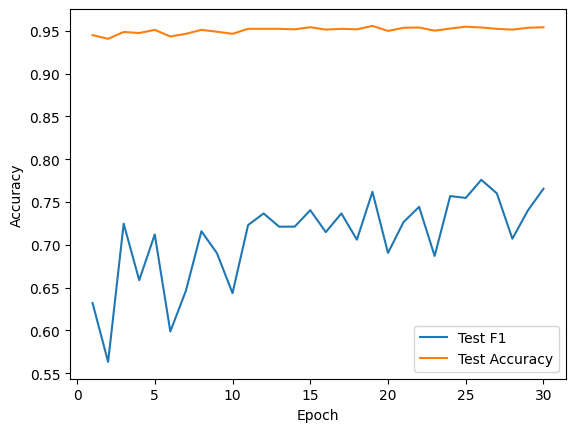

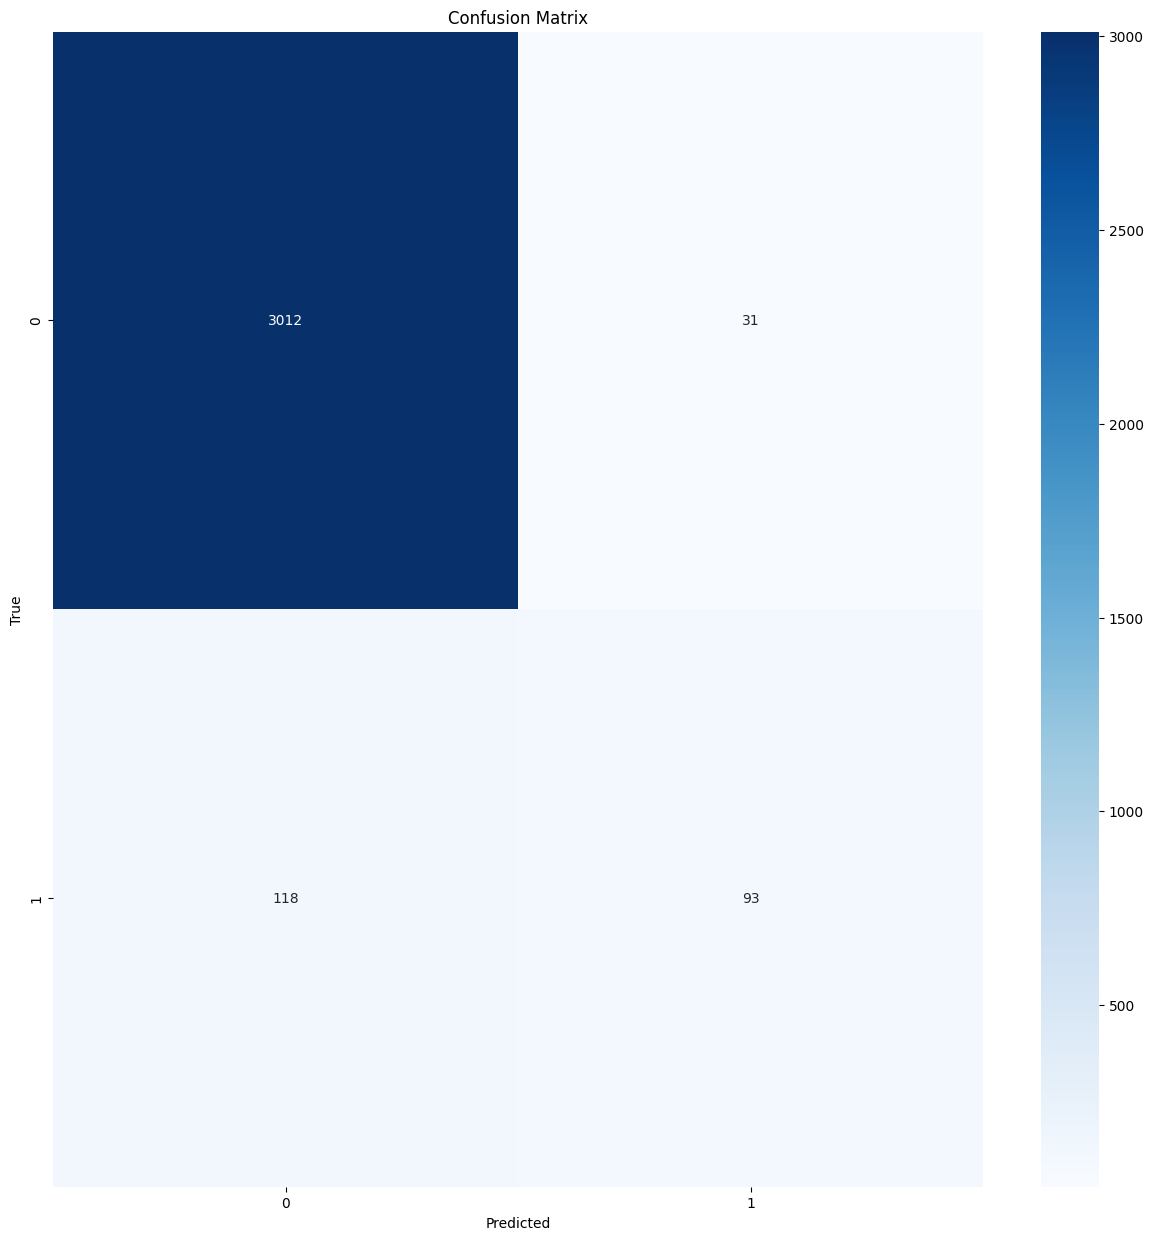

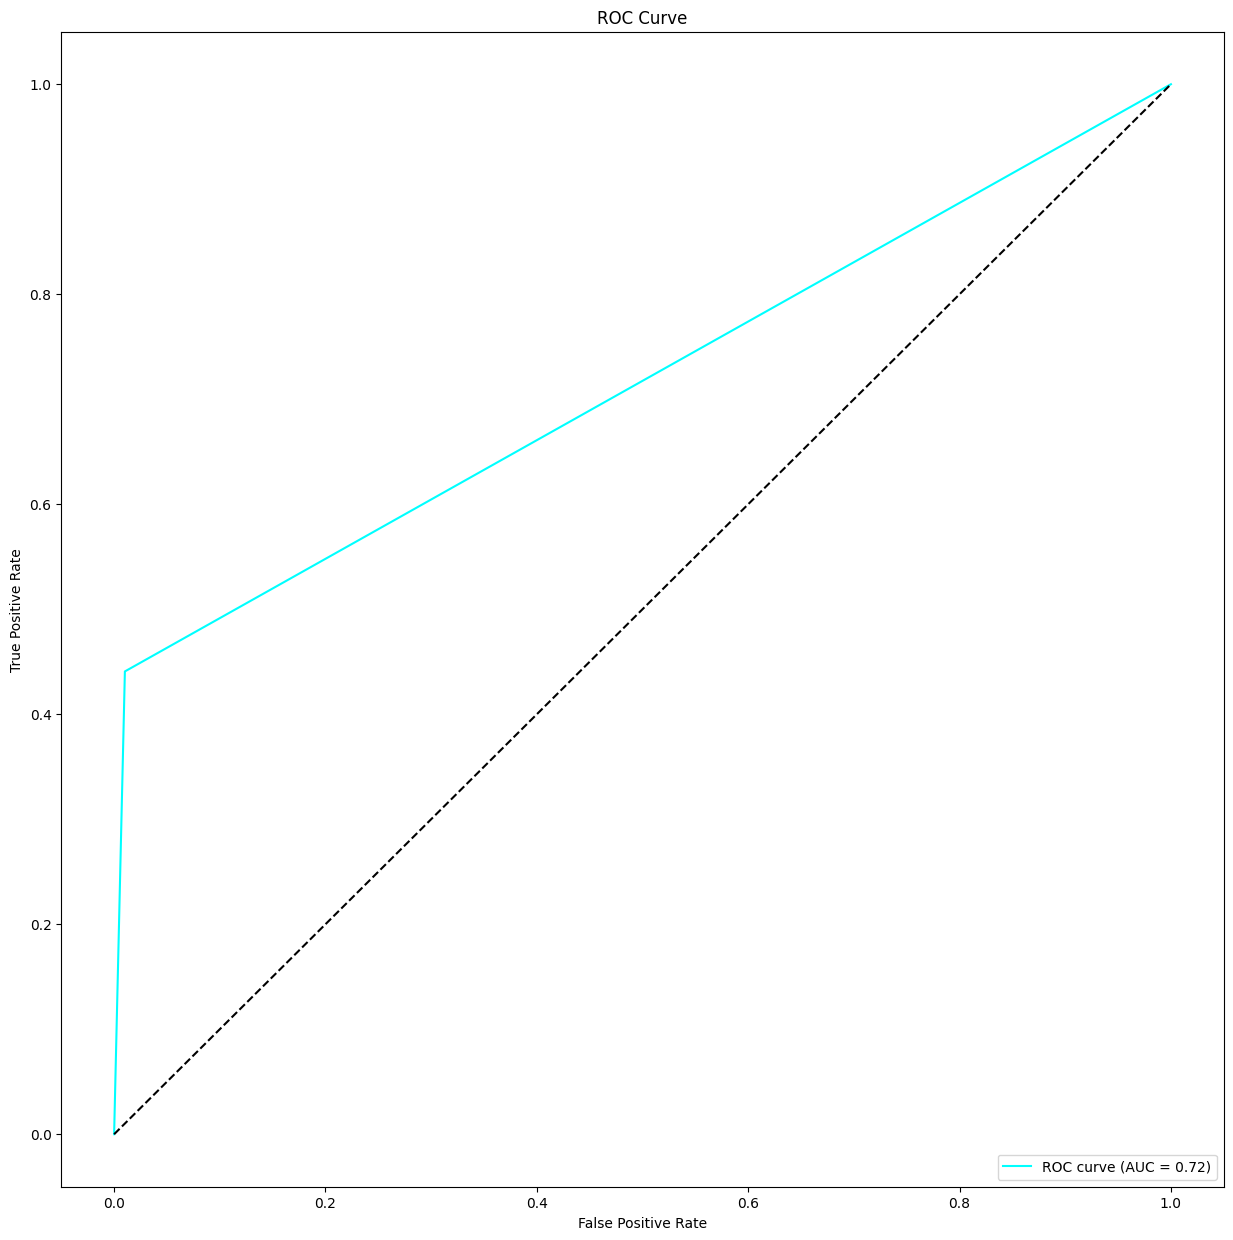

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      3043
         1.0       0.75      0.44      0.56       211

    accuracy                           0.95      3254
   macro avg       0.86      0.72      0.77      3254
weighted avg       0.95      0.95      0.95      3254



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 98817
Epoch 1/30 - Test Accuracy: 0.9447, macro-f1: 0.6168
Epoch 1/30 - Training Time: 542.80 seconds | Inference Time: 133.46 seconds
Epoch 2/30 - Test Accuracy: 0.9453, macro-f1: 0.6240
Epoch 2/30 - Training Time: 541.92 seconds | Inference Time: 131.89 seconds
Epoch 3/30 - Test Accuracy: 0.9508, macro-f1: 0.7055
Epoch 3/30 - Training Time: 543.75 seconds | Inference Time: 132.58 seconds
Epoch 4/30 - Test Accuracy: 0.9499, macro-f1: 0.6884
Epoch 4/30 - Training Time: 543.57 seconds | Inference Time: 133.26 seconds
Epoch 5/30 - Test Accuracy: 0.9462, macro-f1: 0.6374
Epoch 5/30 - Training Time: 543.05 seconds | Inference Time: 133.41 seconds
Epoch 6/30 - Test Accuracy: 0.9478, macro-f1: 0.6595
Epoch 6/30 - Training Time: 542.75 seconds | Inference Time: 132.23 seconds
Epoch 7/30 - Test Accuracy: 0.9518, macro-f1: 0.7597
Epoch 7/30 - Training Time: 543.47 seconds | Inference Time: 133.60 seconds
Epoch 8/30 - Test Ac

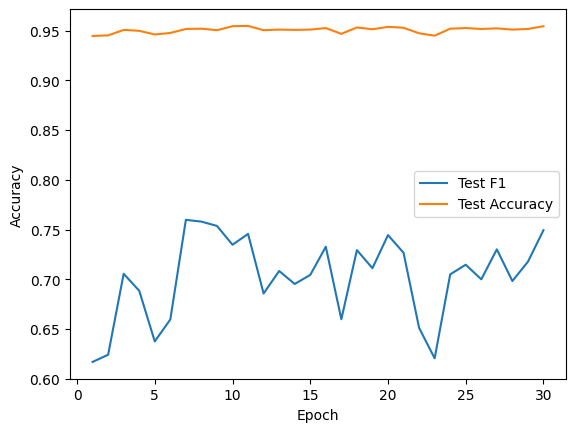

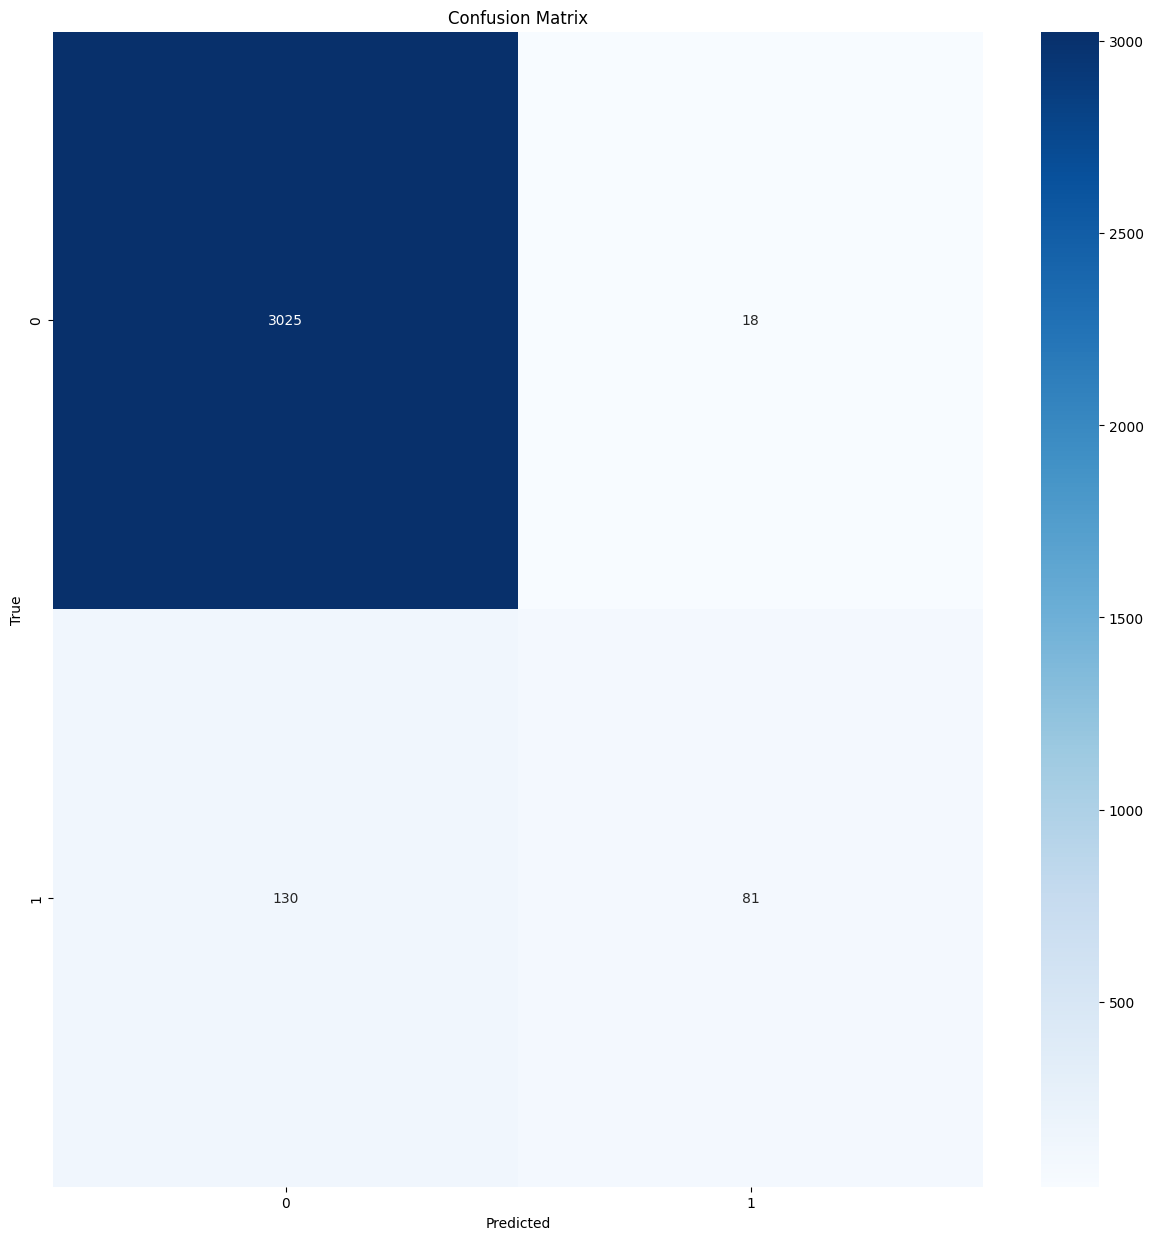

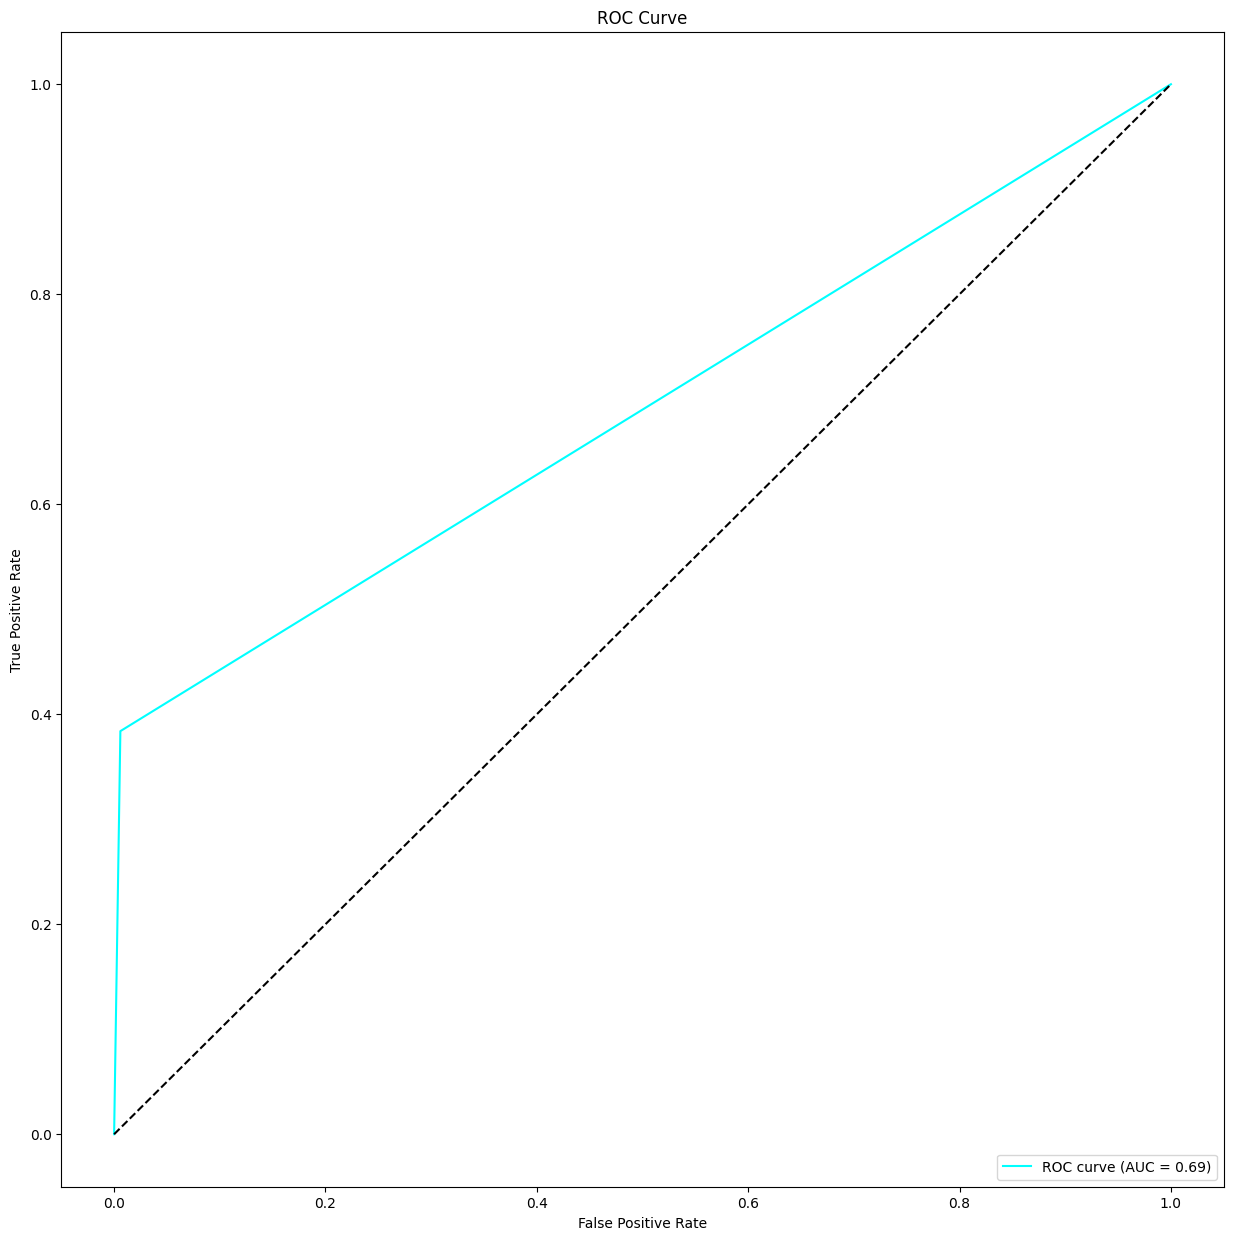

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      3043
         1.0       0.82      0.38      0.52       211

    accuracy                           0.95      3254
   macro avg       0.89      0.69      0.75      3254
weighted avg       0.95      0.95      0.95      3254



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, freeze_backbone=True)